In [9]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from arch import arch_model

In [11]:
def fetch_data(crypto, days=365):
    """
    Fetches historical price data for a cryptocurrency from CoinGecko.
    
    Parameters:
        crypto (str): Cryptocurrency ID (e.g., 'bitcoin')
        days (int): Number of days of historical data
    
    Returns:
        pd.DataFrame: DataFrame with price data and log returns
    """
    url = f"https://api.coingecko.com/api/v3/coins/{crypto}/market_chart?vs_currency=usd&days={days}&interval=daily"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        prices = response.json()['prices']
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df['returns'] = np.log(df['price'] / df['price'].shift(1))
    df.dropna(inplace=True)
    
    if df.empty:
        raise ValueError(f"No data available for {crypto} after cleaning")
    
    return df

def fit_garch(data, p=1, q=1, model_type='GARCH'):
    """
    Fits GARCH model to financial returns
    
    Parameters:
        data (pd.DataFrame): DataFrame containing returns
        p (int): GARCH order
        q (int): ARCH order
        model_type (str): Model type (GARCH/EGARCH/GJR-GARCH)
    
    Returns:
        model_result: Fitted GARCH model
        pd.DataFrame: DataFrame with volatility estimates
    """
    if model_type == 'GARCH':
        model = arch_model(data['returns'], vol='Garch', p=p, q=q)
    elif model_type == 'EGARCH':
        model = arch_model(data['returns'], vol='EGARCH', p=p, q=q)
    elif model_type == 'GJR-GARCH':
        model = arch_model(data['returns'], vol='GARCH', p=p, q=q, o=1)
    else:
        raise ValueError("Supported models: GARCH/EGARCH/GJR-GARCH")
    
    result = model.fit(disp='off')
    data['conditional_volatility'] = result.conditional_volatility
    return result, data

def compare_models(data):
    """Compares different volatility models and recommends the best"""
    models = {
        'GARCH(1,1)': arch_model(data['returns'], vol='Garch', p=1, q=1),
        'EGARCH(1,1)': arch_model(data['returns'], vol='EGARCH', p=1, q=1),
        'GJR-GARCH(1,1)': arch_model(data['returns'], vol='GARCH', p=1, q=1, o=1)
    }
    
    results = {}
    print("\nModel Comparison:")
    for name, model in models.items():
        res = model.fit(disp='off')
        results[name] = {
            'AIC': res.aic,
            'BIC': res.bic
        }
        print(f"{name}: AIC={res.aic:.2f}, BIC={res.bic:.2f}")
    
    best_aic = min(results.items(), key=lambda x: x[1]['AIC'])
    best_bic = min(results.items(), key=lambda x: x[1]['BIC'])
    
    print(f"\nRecommended model by AIC: {best_aic[0]} (AIC={best_aic[1]['AIC']:.2f})")
    print(f"Recommended model by BIC: {best_bic[0]} (BIC={best_bic[1]['BIC']:.2f})")
    
    # Returning the best model by AIC for subsequent analysis
    return best_aic[0], results


=== Bitcoin Analysis ===

Model Comparison:
GARCH(1,1): AIC=-1603.47, BIC=-1587.87
EGARCH(1,1): AIC=-1603.68, BIC=-1588.08
GJR-GARCH(1,1): AIC=-1602.56, BIC=-1583.06

Recommended model by AIC: EGARCH(1,1) (AIC=-1603.68)
Recommended model by BIC: EGARCH(1,1) (BIC=-1588.08)

=== Ethereum Analysis ===

Model Comparison:
GARCH(1,1): AIC=-1436.72, BIC=-1421.12
EGARCH(1,1): AIC=-1438.50, BIC=-1422.90
GJR-GARCH(1,1): AIC=-1447.74, BIC=-1428.24

Recommended model by AIC: GJR-GARCH(1,1) (AIC=-1447.74)
Recommended model by BIC: GJR-GARCH(1,1) (BIC=-1428.24)

Fitting EGARCH(1,1) for Bitcoin...
Fitting GJR-GARCH(1,1) for Ethereum...


c:\Users\Aditya Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\Aditya Pratap Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  war

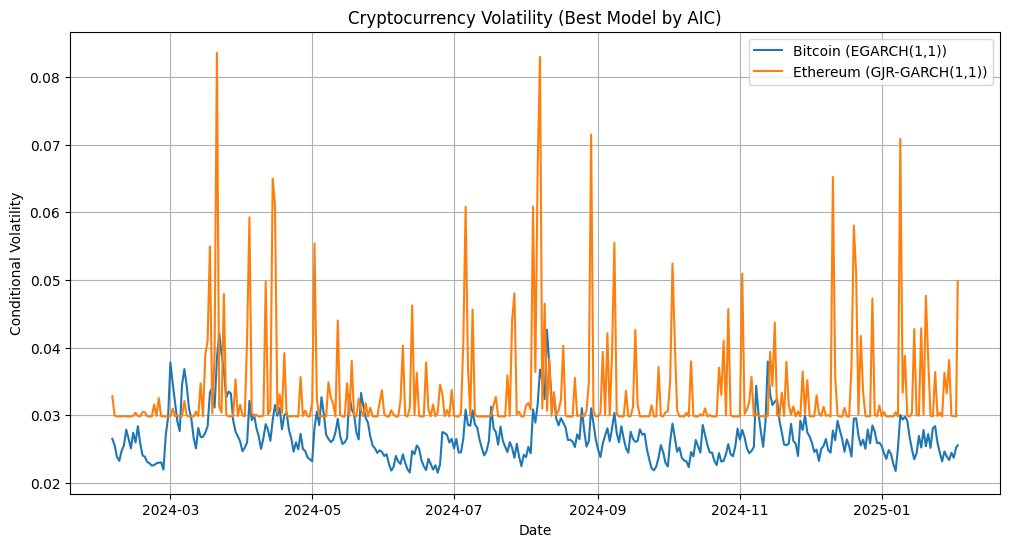

In [ ]:
def main():
    # Fetching the data
    btc = fetch_data('bitcoin')
    eth = fetch_data('ethereum')
    
    # Model comparison and selection
    print("\n=== Bitcoin Analysis ===")
    btc_best_model, btc_results = compare_models(btc)
    print("\n=== Ethereum Analysis ===")
    eth_best_model, eth_results = compare_models(eth)
    
    # Fit best models
    print(f"\nFitting {btc_best_model} for Bitcoin...")
    btc_result, btc = fit_garch(btc, model_type=btc_best_model.split('(')[0])
    print(f"Fitting {eth_best_model} for Ethereum...")
    eth_result, eth = fit_garch(eth, model_type=eth_best_model.split('(')[0])
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(btc['conditional_volatility'], label=f'Bitcoin ({btc_best_model})')
    plt.plot(eth['conditional_volatility'], label=f'Ethereum ({eth_best_model})')
    plt.title('Cryptocurrency Volatility (Best Model by AIC)')
    plt.xlabel('Date')
    plt.ylabel('Conditional Volatility')
    plt.legend()
    plt.grid(True)
    plt.savefig('volatility_plot.png')
    plt.show()

if __name__ == '__main__':
    main()

The GJR-GARCH(1,1) model has the lowest AIC and BIC values, making it the best choice for modeling Bitcoin volatility.
This suggests that Bitcoin's volatility exhibits asymmetric effects (e.g., negative shocks have a larger impact than positive shocks), which GJR-GARCH captures better than standard GARCH or EGARCH.

Insights:
Volatility Clustering: Periods of high volatility are often followed by more high volatility, and periods of low volatility are followed by more low volatility.

Comparison of BTC and ETH: The plot allows us to compare the volatility patterns of Bitcoin and Ethereum.In the graph
Bitcoin  shows more stable volatility over time.
Ethereum exhibit more frequent spikes in volatility, reflecting its higher sensitivity to market events.
Impact of Events: Sudden spikes in volatility may correspond to major market events (e.g., regulatory announcements, macroeconomic news).